Otimização da Função de Ackley

Grupo: Anderson Carneiro da Silva (acs6@cin.ufpe.br) e Lucas Thierry Chaves Muniz (ltcm@cin.ufpe.br)

In [46]:
from numpy import pi
from numpy import cos
from numpy import exp
from numpy import sqrt

Função Fitness

In [47]:
def ackley (vector, c1=20, c2=0.2, c3=2*pi):
    d = len(vector)
    sqrt_sum=0
    cos_sum=0
    for elem in vector:
        sqrt_sum += elem**2
        cos_sum += cos(c3*elem)
    
    sqrt_term = -c1 * exp(-c2*(sqrt(sqrt_sum/d)))
    cos_term = -exp(cos_sum/d)

    return sqrt_term + cos_term + c1 + exp(1)

In [48]:
print(ackley([0, 0, 0, 0]))

4.440892098500626e-16


In [49]:
import numpy as np
from abc import ABC, abstractmethod


class Individual(ABC):
    def __init__(self, value=None, init_params=None):
        if value is not None:
            self.value = value
        else:
            self.value = self._random_init(init_params)

    @abstractmethod
    def pair(self, other, pair_params):
        pass

    @abstractmethod
    def mutate(self, mutate_params):
        pass

    @abstractmethod
    def _random_init(self, init_params):
        pass


class Optimization(Individual):
    def pair(self, other, pair_params):
        return Optimization(pair_params['alpha'] * self.value + (1 - pair_params['alpha']) * other.value)

    def discreet_recomb(self, other):
        for i in range(len(self.value)):
            choice = np.random.randint(2)
            if choice==1:
                self.value[i] = other.value[i]
        return Optimization(self.value)

    def intermediate_recomb(self, other, init_params, d=0.25):
            lower_bound=init_params['lower_bound']
            upper_bound=init_params['upper_bound']
            for i in range(len(self.value)):
                spread = self.value[i]-other.value[i]
                inter_min_bound = (min(self.value[i], other.value[i]))-d*spread
                inter_max_bound = (max(self.value[i], other.value[i]))+d*spread
                if inter_min_bound < lower_bound:
                    inter_min_bound = lower_bound
                if inter_max_bound > upper_bound:
                    inter_max_bound = upper_bound
                self.value[i] = np.random.uniform(inter_min_bound, inter_max_bound)
            return Optimization(self.value)

    def mutate(self, mutate_params):
        self.value += np.random.normal(0, mutate_params['rate'], mutate_params['dim'])
        for i in range(len(self.value)):
            if self.value[i] < mutate_params['lower_bound']:
                self.value[i] = mutate_params['lower_bound']
            elif self.value[i] > mutate_params['upper_bound']:
                self.value[i] = mutate_params['upper_bound']

    def _random_init(self, init_params):
        return np.random.uniform(init_params['lower_bound'], init_params['upper_bound'], init_params['dim'])


class Population:
    def __init__(self, size, fitness, individual_class, init_params):
        self.fitness = fitness
        self.individuals = [individual_class(init_params=init_params) for _ in range(size)]
        self.individuals.sort(key=lambda x: self.fitness(x))

    def replace(self, new_individuals):
        size = len(self.individuals)
        self.individuals.extend(new_individuals)
        self.individuals.sort(key=lambda x: self.fitness(x))
        self.individuals = self.individuals[-size:]

    def replace_comma(self, new_individuals):
        size = len(self.individuals)
        new_individuals.sort(key=lambda x: self.fitness(x))
        self.individuals = new_individuals[-size:]

    
    def makeWheel(self, population):
        wheel = []
        total = sum(fitness(p) for p in population)
        top = 0
        for p in population:
            f = fitness(p)/total
            wheel.append((top, top+f, p))
            top += f
        return wheel

    def binSearch(self, wheel, num):
        mid = len(wheel)//2
        low, high, answer = wheel[mid]
        if low<=num<=high:
            return answer
        elif high < num:
            return self.binSearch(wheel[mid+1:], num)
        else:
            return self.binSearch(wheel[:mid], num)

    def select(self, wheel, N):
        stepSize = 1.0/N
        answer = []
        r = np.random.random()
        answer.append(self.binSearch(wheel, r))
        while len(answer) < N:
            r += stepSize
            if r>1:
                r %= 1
            answer.append(self.binSearch(wheel, r))
        return answer

    def get_parents(self, n_offsprings, parent_select):
        if (parent_select == 'elite'):
            mothers = self.individuals[-2 * n_offsprings::2]
            fathers = self.individuals[-2 * n_offsprings + 1::2]

        if (parent_select == 'stochastic'):
            popWheel = self.makeWheel(self.individuals)
            parents = self.select(popWheel, n_offsprings)

            mothers = parents[0::int(len(parents)/2)]
            fathers = parents[int(((len(parents)/2)+1))::len(parents)]

        return mothers, fathers


class Evolution:
    def __init__(self, pool_size, fitness, individual_class, n_offsprings, survival_select, \
         recomb_type, pair_params, mutate_params, init_params, parent_select):
        self.pair_params = pair_params
        self.mutate_params = mutate_params
        self.pool = Population(pool_size, fitness, individual_class, init_params)
        self.n_offsprings = n_offsprings
        self.survival_select=survival_select
        self.recomb_type=recomb_type
        self.init_params=init_params
        self.parent_select = parent_select

    def step(self):
        mothers, fathers = self.pool.get_parents(self.n_offsprings, self.parent_select)
        offsprings = []

        for mother, father in zip(mothers, fathers):
            if(self.recomb_type == 'simple_pair'):
                offspring = mother.pair(father, self.pair_params)
            if(self.recomb_type == 'discreet'):
                offspring = mother.discreet_recomb(father)
            if(self.recomb_type == 'intermediate'):
                offspring = mother.intermediate_recomb(father, self.init_params)
            offspring.mutate(self.mutate_params)
            offsprings.append(offspring)

        if(self.survival_select=='comma'):
            self.pool.replace_comma(offsprings)
        elif(self.survival_select=='plus'):
            self.pool.replace(offsprings)

[ 0.30471336 -0.05166679 -0.03398658 -0.0706044   0.07843124 -0.12388182
 -0.03488913  0.23332267  0.16382506 -0.0956825  -0.07889234 -0.44040832
 -0.02543409 -0.12972154 -0.06647754  0.12381218 -0.26175308 -0.01475312
 -0.11480543  0.01534598 -0.26487224  0.07104574 -0.01489323  0.2088704
 -0.14046039  0.10172976  0.06273877  0.09074058  0.0373282   0.06911012]
0.7136815334926295


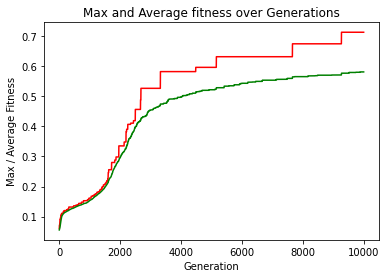

[-0.21612931 -0.15324229  0.02087817 -0.04201063  0.01737676  0.24295212
  0.12257704  0.03305481 -0.0376771  -0.06252833  0.28273995 -0.35095653
 -0.12755896 -0.12243065 -0.13519665  0.02813467  0.1717959   0.07126418
  0.19382124  0.00237911 -0.08574356 -0.32754898 -0.05539936  0.1022078
 -0.10035113  0.00923864  0.13736786 -0.29515774  0.05467249 -0.03297468]
0.6784817333021884


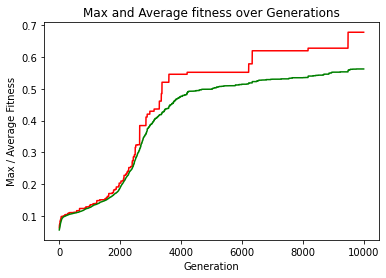

[-1.21737330e-01 -5.23957981e-02  2.36749484e-01  1.45557925e-04
 -1.14666378e-01 -2.31366705e-01  2.05956867e-02  2.39864615e-02
  4.31508366e-02  1.29875875e-01  4.15513304e-02 -7.59943496e-02
  8.28837910e-02 -1.46111235e-01 -3.44522819e-03  3.26375261e-02
  3.58466805e-01 -6.23246569e-02  3.63561883e-02 -4.60109263e-02
 -4.29774139e-01 -1.50606355e-02 -1.56932840e-01 -3.19196442e-02
  3.42582058e-01  2.51112772e-01  2.47912839e-01 -1.48319314e-02
 -2.40960312e-01  6.38556718e-02]
0.6380683507874128


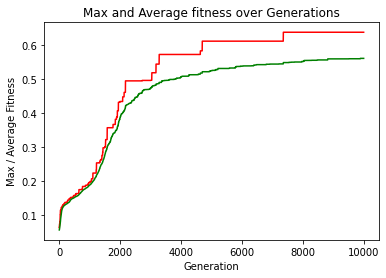

simple_pair Recombination - plus Survival - average best fitness 0.6767438725274101
Highest fitness 0.7136815334926295


In [50]:
import matplotlib.pyplot as plt

def fitness(vector):
    return 1/ackley(vector.value)

# Parameters
xi_min = -15
xi_max = 15
dimensions = 30
generations = 50000
tries_per_params = 3
parent_select_param = 'stochastic'

variable_params_dict_default = {'pool_size': 30, 'fitness': fitness, 'individual_class': Optimization, \
    'n_offsprings': 15, 'survival_select': 'plus', 'recomb_type': 'intermediate', 'parent_select': parent_select_param}
pair_params_dict_default = {'alpha': 0.5}
mutate_params_dict_default = {'lower_bound': xi_min, 'upper_bound': xi_max, 'rate': 0.25, 'dim': dimensions}
init_params_dict_default = {'lower_bound': xi_min, 'upper_bound': xi_max, 'dim': dimensions}

# List for "grid search"

# surv_list = ['comma', 'plus']
# recomb_list = ['simple_pair', 'discreet', 'intermediate']

surv_list = ['plus']
recomb_list = ['simple_pair']

for recomb in recomb_list:
    for surv in surv_list:
        tries_fitness_list=[]
        for z in range(tries_per_params):
            variable_params_dict = variable_params_dict_default
            pair_params_dict = pair_params_dict_default
            mutate_params_dict = mutate_params_dict_default
            init_params_dict = init_params_dict_default
            variable_params_dict['survival_select'] = surv
            variable_params_dict['recomb_type'] = recomb
            evo = Evolution(
                pool_size = variable_params_dict['pool_size'], fitness = variable_params_dict['fitness'], \
                    individual_class = variable_params_dict['individual_class'], \
                        n_offsprings = variable_params_dict['n_offsprings'], \
                            survival_select = variable_params_dict['survival_select'], \
                                recomb_type = variable_params_dict['recomb_type'], \
                                    parent_select = variable_params_dict['parent_select'],
                pair_params=pair_params_dict,
                mutate_params=mutate_params_dict,
                init_params=init_params_dict
            )

            maxFitnessValues = []
            meanFitnessValues = []
            for i in range(generations):
                evo.step()
                best_individual = evo.pool.individuals[-1]
                best_fitness = fitness(best_individual)
                maxFitnessValues.append(best_fitness)
                avg = 0
                for e in evo.pool.individuals:
                    avg += fitness(e)
                meanFitnessValues.append(avg/(len(evo.pool.individuals)))
                if best_fitness > (1/0.1):
                    break

            tries_fitness_list.append(best_fitness)
            print(best_individual.value)
            print(best_fitness)

            plt.plot(maxFitnessValues, color='red')
            plt.plot(meanFitnessValues, color='green')
            plt.xlabel('Generation')
            plt.ylabel('Max / Average Fitness')
            plt.title('Max and Average fitness over Generations')

            plt.show()
        print(f'{recomb} Recombination - {surv} Survival - average best fitness {np.mean(tries_fitness_list)}')
        print(f'Highest fitness {max(tries_fitness_list)}')